# Ship Sinking Probability

Before the appearance of curse cards, the number of blank outcomes directly related to the probability a ship would sink after attempting an endeavor. However, since the deck of damage cards has been divided into two sub-types that contribute independently to the sinking of a ship, the number of blank outcomes no longer fully relects the chance of sinking. The initial damage deck consists of **20 standard damage cards**. There are **18 curse cards** added to the damage deck once the corresponding box is opened. This near coin-flip between drawing a curse or standard damage makes it considerably less likely a ship will sink and should encourage undertaking bold endeavors.

In [1]:
%matplotlib inline

import itertools
import matplotlib
import matplotlib.pyplot
import numpy
import os
import pandas
import scipy.misc
import scipy.special
import scipy.stats
import seaborn

In [2]:
# colormap for data visualizations
cmap = seaborn.cubehelix_palette(n_colors = 20, start = 0.8, rot = 0.75,
                                gamma = 0.3, hue = 2.0, dark = 0.005,
                                light = 0.95, reverse = False, as_cmap = True)

Drawing cards shares similarities with rolling dice and would be equivalent if drawing from a deck of infinite size. However, the damage deck size is relatively small and the distribution of damage cards amongst the ships in play will have an impact on the probability of sinking a ship. However, the distributions may be similar enough that the starting configuration of a full damage deck may prove useful even when several damage cards are in play.

The math will be the same as finding the probabilities of poker hands.

In [3]:
damage_num = 20
curse_num = 18
deck_size = damage_num + curse_num

After the "relic" event there are two ways that ships sink: collecting 3 standard damage cards (referred to throughout as just damage cards) or collecting 3 curse cards. Note that, even though curse cards and damage cards are pulled from the same deck, a ship can accumulate any combination of damage or curse cards until the threshold of 3 is reached, so their effect on sinking is independent of each other. Thus, sinking a ship includes some chance and fortune.

To calculate the probability of sinking we must account for the probability of sinking via curses or sinking via damage. The equation for this probability is P(AorB) = P(A) + P(B) - P(AandB).

In [4]:
def sink_probability_curse(dmg_num, crs_num, hand_size, thresh_crs):
    """
    * dmg_num: the number of standard damage cards in the damage deck
    * crs_num: the number of curse cards in the damage deck
    * hand_size: the number of cards to be drawn from the damage deck
    * thresh_crs: the number of curse cards that will cause a ship to sink, e.g. if a ship already has 1 curse card, the thresh_crs would be 2 since 3 curse cards would sink the ship.
    """
    deck_size = dmg_num + crs_num
    p_sink = 0.0
    if hand_size - dmg_num >= thresh_crs:
        p_sink = 1.0
    elif hand_size >= thresh_crs:
        hand_array = numpy.arange(0,thresh_crs)
        for i in hand_array:
            p_sink += scipy.misc.comb(crs_num, i) \
            * scipy.misc.comb(deck_size-crs_num, hand_size-i) \
            / scipy.misc.comb(deck_size, hand_size)
        p_sink = 1-p_sink
    return p_sink

def sink_probability_damage(dmg_num, crs_num, hand_size, thresh_dmg):
    deck_size = dmg_num + crs_num
    p_sink = 0.0
    if hand_size - crs_num >= thresh_dmg:
        p_sink = 1.0
    elif hand_size >= thresh_dmg:
        hand_array = numpy.arange(0,thresh_dmg)
        for i in hand_array:
            p_sink += scipy.misc.comb(dmg_num, i) \
            * scipy.misc.comb(deck_size-dmg_num, hand_size-i) \
            / scipy.misc.comb(deck_size, hand_size)
        p_sink = 1.0 - p_sink
        
    return p_sink

def sink_probability_dmg_and_crs(dmg_num, crs_num, hand_size, thresh_dmg, thresh_crs):
    """
    What is the probability the number of damage cards and curse cards exceed the number required to sink a ship?
    """
    deck_size = dmg_num + crs_num
    p_sink = 0.0
    if hand_size - crs_num >= thresh_dmg and hand_size - dmg_num >= thresh_crs:
        p_sink = 1.0
    elif hand_size >= thresh_dmg + thresh_crs:
        hand_array_dmg = numpy.arange(0,thresh_dmg)
        hand_array_crs = numpy.arange(0,thresh_crs)
        for i in hand_array_dmg:
            p_sink += scipy.misc.comb(dmg_num, i) \
            * scipy.misc.comb(deck_size-dmg_num, hand_size-i) \
            / scipy.misc.comb(deck_size, hand_size)
        for i in hand_array_crs:
            p_sink += scipy.misc.comb(crs_num, i) \
            * scipy.misc.comb(deck_size-crs_num, hand_size-i) \
            / scipy.misc.comb(deck_size, hand_size)
        p_sink = 1.0 - p_sink
    return p_sink

def sink_probability(dmg_num, crs_num, hand_size, thresh_dmg, thresh_crs):
    if hand_size > dmg_num + crs_num:
        raise ValueError('The *hand_size* cannot be larger than the number of cards in the deck.')
    
    p_dmg = sink_probability_damage(dmg_num, crs_num, hand_size, thresh_dmg)
    p_crs = sink_probability_curse(dmg_num, crs_num, hand_size, thresh_crs)
    p_and = sink_probability_dmg_and_crs(dmg_num, crs_num, hand_size, thresh_dmg, thresh_crs)
    p_sink = p_dmg + p_crs - p_and
    return p_sink

The curse cards make a significant change to how likely a ship is to sink (or an endeavor is to fail). Curses reduce the chances of failure via sinking considerably (and this probability is >> than the chance of rolling all blanks, which is the only other way to fail an endeavor). This means a much more aggressive strategy should be adopted when choosing to attempt an endeavor.

In [5]:
sink_probability(damage_num, curse_num, 1, 3, 1)

0.47368421052631582

While there is some poker math involved with finding the probability that a ship will sink, the decision-making is straigtforward given the small number of relevant possibilities. Given a healthly ship: 1 or 2 damage will not sink it, 3 or 4 may sink it, 5 or more will 100% sink the ship.

In [6]:
row_dmg = numpy.arange(3,0,-1) # the thresholds for standard damage, i.e. 3 minus the number of standard damage on a ship
col_crs = numpy.arange(3,0,-1) # the thresholds for curse damage, i.e. 3 minus the number of curses on a ship
hand_array = numpy.arange(1,6) # number of cards drawn from the damage deck

prob = [sink_probability(damage_num + j - 3, curse_num + k - 3, i, j, k) for i, j, k in itertools.product(hand_array, row_dmg, col_crs)]

ind_dmg = numpy.arange(0,3)
ind_crs = numpy.arange(0,3)
ind = numpy.asarray([i for i in itertools.product(hand_array, ind_dmg, ind_crs)])

d = {"number_damage" : ind[:,1], "number_curse" : ind[:,2], "hand_size" : ind[:,0], "probability_sink" : prob}

ssp_dataframe = pandas.DataFrame(data = d)

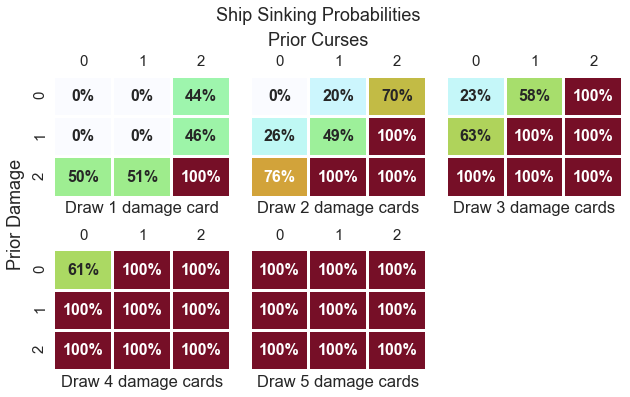

In [7]:
seaborn.set(style = "white")
seaborn.set_context("poster")
seaborn.set(font_scale = 1.5)
matplotlib.pyplot.figure(figsize=(18, 12))
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = seaborn.heatmap(d, annot = True, cmap = cmap,
                     cbar = False, annot_kws = {"weight" : "extra bold", "size" : 16},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
    ax.set_xlabel("Prior Curses")
    ax.set_ylabel("Prior Damage")

grid = seaborn.FacetGrid(ssp_dataframe, col="hand_size", col_wrap=3)
grid.map_dataframe(draw_heatmap, "number_curse", "number_damage", "probability_sink")
grid.axes[0].set_xlabel("Draw 1 damage card")
grid.axes[1].set_xlabel("Draw 2 damage cards")
grid.axes[2].set_xlabel("Draw 3 damage cards")
grid.axes[3].set_xlabel("Draw 4 damage cards")
grid.axes[4].set_xlabel("Draw 5 damage cards")
grid.axes[0].set_ylabel('')
grid.axes[3].set_ylabel('')
grid.axes[0].set_title("")
grid.axes[1].set_title("")
grid.axes[2].set_title("")
grid.axes[3].set_title("")
grid.axes[4].set_title("")
grid.axes[0].xaxis.tick_top()
grid.axes[1].xaxis.tick_top()
grid.axes[2].xaxis.tick_top()
grid.axes[3].xaxis.tick_top()
grid.axes[4].xaxis.tick_top()
matplotlib.pyplot.subplots_adjust(top=0.82)
matplotlib.pyplot.suptitle('Ship Sinking Probabilities', fontsize=18)
grid.fig.text(0.5, 0.89, 'Prior Curses', ha='center', fontsize=18)
grid.fig.text(0.02, 0.5, 'Prior Damage', va='center', rotation='vertical', fontsize=18)
grid.fig.savefig(os.path.join("charts","ship_sinking_probabilities.pdf"))
grid.fig.savefig(os.path.join("charts",'ship_sinking_probabilities.svg'), format='svg', dpi=1200)

What happens if there are a fair number of damage cards distributed amongst the ships? How different are the probabilities? Let's consider the case where 6 curses are in play (note this is an extreme situation with a < 1% chance of happening). We find that there is noticable difference in the probabilities.

However, since this is such a rare situation let's also consider more likely situations where 8 cards are in play. The most common outcome is 4 curses and 4 damage. The set of (5,3), (4,4), and (3,5) outcomes occurs 76% of the time.

The *ideal* probabilities are calculated when there is no damage or the only damage in play is on the ship attempting the endeavor. After comparing the ideal probabilities to the set of 3 typical 8 cards-in-play probabilities, I conclude that the ideal probabilities are similar enough in value to the most common damage cards-in-play configurations that the ideal probabilities are good enough for an in-game player aid.

In [8]:
scipy.misc.comb(18, 5) \
* scipy.misc.comb(20, 3) \
/ scipy.misc.comb(38, 8) + \
scipy.misc.comb(18, 4) \
* scipy.misc.comb(20, 4) \
/ scipy.misc.comb(38, 8) + \
scipy.misc.comb(18, 3) \
* scipy.misc.comb(20, 5) \
/ scipy.misc.comb(38, 8)

0.76159150352698735

In [9]:
damage_num = 20
curse_num = 12
row_dmg = numpy.arange(3,0,-1) # the thresholds for standard damage, i.e. 3 minus the number of standard damage on a ship
col_crs = numpy.arange(3,0,-1) # the thresholds for curse damage, i.e. 3 minus the number of curses on a ship
hand_array = numpy.arange(1,6) # number of cards drawn from the damage deck

prob = [sink_probability(damage_num + j - 3, curse_num + k - 3, i, j, k) for i, j, k in itertools.product(hand_array, row_dmg, col_crs)]

ind_dmg = numpy.arange(0,3)
ind_crs = numpy.arange(0,3)
ind = numpy.asarray([i for i in itertools.product(hand_array, ind_dmg, ind_crs)])

d = {"number_damage" : ind[:,1], "number_curse" : ind[:,2], "hand_size" : ind[:,0], "probability_sink" : prob}

ssp_dataframe2 = pandas.DataFrame(data = d)

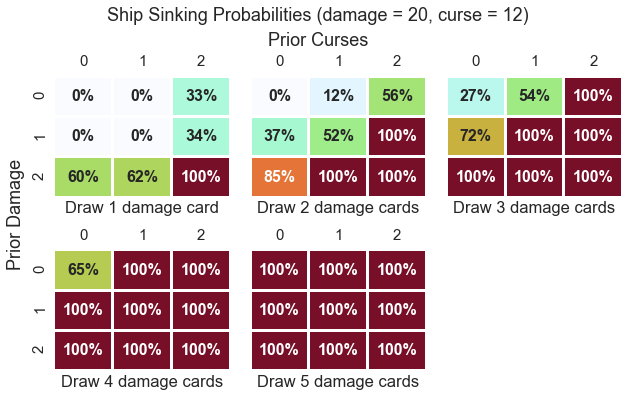

In [10]:
seaborn.set(style = "white")
seaborn.set_context("poster")
seaborn.set(font_scale = 1.5)
matplotlib.pyplot.figure(figsize=(18, 12))
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = seaborn.heatmap(d, annot = True, cmap = cmap,
                     cbar = False, annot_kws = {"weight" : "extra bold", "size" : 16},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
    ax.set_xlabel("Prior Curses")
    ax.set_ylabel("Prior Damage")

grid = seaborn.FacetGrid(ssp_dataframe2, col="hand_size", col_wrap=3)
grid.map_dataframe(draw_heatmap, "number_curse", "number_damage", "probability_sink")
grid.axes[0].set_xlabel("Draw 1 damage card")
grid.axes[1].set_xlabel("Draw 2 damage cards")
grid.axes[2].set_xlabel("Draw 3 damage cards")
grid.axes[3].set_xlabel("Draw 4 damage cards")
grid.axes[4].set_xlabel("Draw 5 damage cards")
grid.axes[0].set_ylabel('')
grid.axes[3].set_ylabel('')
grid.axes[0].set_title("")
grid.axes[1].set_title("")
grid.axes[2].set_title("")
grid.axes[3].set_title("")
grid.axes[4].set_title("")
grid.axes[0].xaxis.tick_top()
grid.axes[1].xaxis.tick_top()
grid.axes[2].xaxis.tick_top()
grid.axes[3].xaxis.tick_top()
grid.axes[4].xaxis.tick_top()
matplotlib.pyplot.subplots_adjust(top=0.82)
matplotlib.pyplot.suptitle('Ship Sinking Probabilities (damage = 20, curse = 12)', fontsize=18)
grid.fig.text(0.5, 0.89, 'Prior Curses', ha='center', fontsize=18)
grid.fig.text(0.02, 0.5, 'Prior Damage', va='center', rotation='vertical', fontsize=18)
grid.fig.savefig(os.path.join("charts",'ship_sinking_probabilities_d12_c12.svg'), format='svg', dpi=1200)

In [11]:
damage_num = 15
curse_num = 15
row_dmg = numpy.arange(3,0,-1) # the thresholds for standard damage, i.e. 3 minus the number of standard damage on a ship
col_crs = numpy.arange(3,0,-1) # the thresholds for curse damage, i.e. 3 minus the number of curses on a ship
hand_array = numpy.arange(1,6) # number of cards drawn from the damage deck

prob = [sink_probability(damage_num + j - 3, curse_num + k - 3, i, j, k) for i, j, k in itertools.product(hand_array, row_dmg, col_crs)]

ind_dmg = numpy.arange(0,3)
ind_crs = numpy.arange(0,3)
ind = numpy.asarray([i for i in itertools.product(hand_array, ind_dmg, ind_crs)])

d = {"number_damage" : ind[:,1], "number_curse" : ind[:,2], "hand_size" : ind[:,0], "probability_sink" : prob}

ssp_dataframe2 = pandas.DataFrame(data = d)

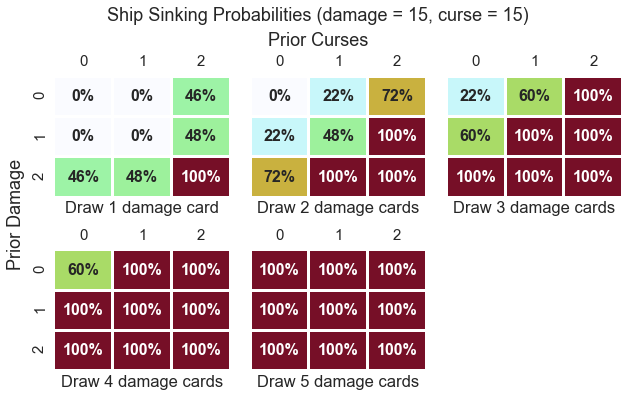

In [12]:
seaborn.set(style = "white")
seaborn.set_context("poster")
seaborn.set(font_scale = 1.5)
matplotlib.pyplot.figure(figsize=(18, 12))
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = seaborn.heatmap(d, annot = True, cmap = cmap,
                     cbar = False, annot_kws = {"weight" : "extra bold", "size" : 16},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
    ax.set_xlabel("Prior Curses")
    ax.set_ylabel("Prior Damage")

grid = seaborn.FacetGrid(ssp_dataframe2, col="hand_size", col_wrap=3)
grid.map_dataframe(draw_heatmap, "number_curse", "number_damage", "probability_sink")
grid.axes[0].set_xlabel("Draw 1 damage card")
grid.axes[1].set_xlabel("Draw 2 damage cards")
grid.axes[2].set_xlabel("Draw 3 damage cards")
grid.axes[3].set_xlabel("Draw 4 damage cards")
grid.axes[4].set_xlabel("Draw 5 damage cards")
grid.axes[0].set_ylabel('')
grid.axes[3].set_ylabel('')
grid.axes[0].set_title("")
grid.axes[1].set_title("")
grid.axes[2].set_title("")
grid.axes[3].set_title("")
grid.axes[4].set_title("")
grid.axes[0].xaxis.tick_top()
grid.axes[1].xaxis.tick_top()
grid.axes[2].xaxis.tick_top()
grid.axes[3].xaxis.tick_top()
grid.axes[4].xaxis.tick_top()
matplotlib.pyplot.subplots_adjust(top=0.82)
matplotlib.pyplot.suptitle('Ship Sinking Probabilities (damage = 15, curse = 15)', fontsize=18)
grid.fig.text(0.5, 0.89, 'Prior Curses', ha='center', fontsize=18)
grid.fig.text(0.02, 0.5, 'Prior Damage', va='center', rotation='vertical', fontsize=18)
grid.fig.savefig(os.path.join("charts",'ship_sinking_probabilities_d15_c15.svg'), format='svg', dpi=1200)

In [13]:
damage_num = 16
curse_num = 14
row_dmg = numpy.arange(3,0,-1) # the thresholds for standard damage, i.e. 3 minus the number of standard damage on a ship
col_crs = numpy.arange(3,0,-1) # the thresholds for curse damage, i.e. 3 minus the number of curses on a ship
hand_array = numpy.arange(1,6) # number of cards drawn from the damage deck

prob = [sink_probability(damage_num + j - 3, curse_num + k - 3, i, j, k) for i, j, k in itertools.product(hand_array, row_dmg, col_crs)]

ind_dmg = numpy.arange(0,3)
ind_crs = numpy.arange(0,3)
ind = numpy.asarray([i for i in itertools.product(hand_array, ind_dmg, ind_crs)])

d = {"number_damage" : ind[:,1], "number_curse" : ind[:,2], "hand_size" : ind[:,0], "probability_sink" : prob}

ssp_dataframe2 = pandas.DataFrame(data = d)

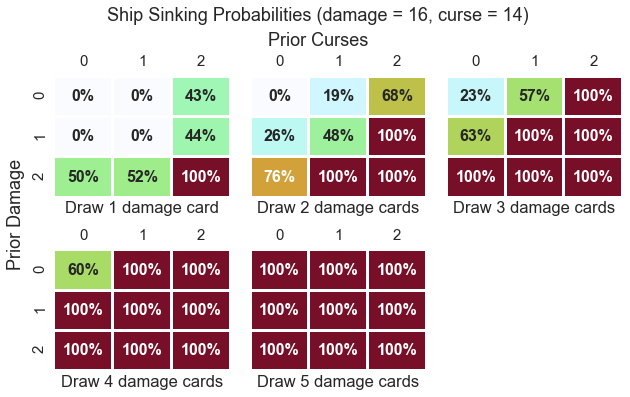

In [14]:
seaborn.set(style = "white")
seaborn.set_context("poster")
seaborn.set(font_scale = 1.5)
matplotlib.pyplot.figure(figsize=(18, 12))
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = seaborn.heatmap(d, annot = True, cmap = cmap,
                     cbar = False, annot_kws = {"weight" : "extra bold", "size" : 16},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
    ax.set_xlabel("Prior Curses")
    ax.set_ylabel("Prior Damage")

grid = seaborn.FacetGrid(ssp_dataframe2, col="hand_size", col_wrap=3)
grid.map_dataframe(draw_heatmap, "number_curse", "number_damage", "probability_sink")
grid.axes[0].set_xlabel("Draw 1 damage card")
grid.axes[1].set_xlabel("Draw 2 damage cards")
grid.axes[2].set_xlabel("Draw 3 damage cards")
grid.axes[3].set_xlabel("Draw 4 damage cards")
grid.axes[4].set_xlabel("Draw 5 damage cards")
grid.axes[0].set_ylabel('')
grid.axes[3].set_ylabel('')
grid.axes[0].set_title("")
grid.axes[1].set_title("")
grid.axes[2].set_title("")
grid.axes[3].set_title("")
grid.axes[4].set_title("")
grid.axes[0].xaxis.tick_top()
grid.axes[1].xaxis.tick_top()
grid.axes[2].xaxis.tick_top()
grid.axes[3].xaxis.tick_top()
grid.axes[4].xaxis.tick_top()
matplotlib.pyplot.subplots_adjust(top=0.82)
matplotlib.pyplot.suptitle('Ship Sinking Probabilities (damage = 16, curse = 14)', fontsize=18)
grid.fig.text(0.5, 0.89, 'Prior Curses', ha='center', fontsize=18)
grid.fig.text(0.02, 0.5, 'Prior Damage', va='center', rotation='vertical', fontsize=18)
grid.fig.savefig(os.path.join("charts",'ship_sinking_probabilities_d16_c14.svg'), format='svg', dpi=1200)

In [15]:
damage_num = 17
curse_num = 13
row_dmg = numpy.arange(3,0,-1) # the thresholds for standard damage, i.e. 3 minus the number of standard damage on a ship
col_crs = numpy.arange(3,0,-1) # the thresholds for curse damage, i.e. 3 minus the number of curses on a ship
hand_array = numpy.arange(1,6) # number of cards drawn from the damage deck

prob = [sink_probability(damage_num + j - 3, curse_num + k - 3, i, j, k) for i, j, k in itertools.product(hand_array, row_dmg, col_crs)]

ind_dmg = numpy.arange(0,3)
ind_crs = numpy.arange(0,3)
ind = numpy.asarray([i for i in itertools.product(hand_array, ind_dmg, ind_crs)])

d = {"number_damage" : ind[:,1], "number_curse" : ind[:,2], "hand_size" : ind[:,0], "probability_sink" : prob}

ssp_dataframe2 = pandas.DataFrame(data = d)

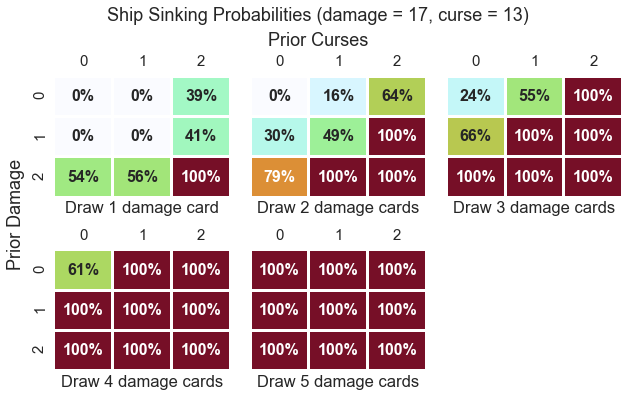

In [16]:
seaborn.set(style = "white")
seaborn.set_context("poster")
seaborn.set(font_scale = 1.5)
matplotlib.pyplot.figure(figsize=(18, 12))
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = seaborn.heatmap(d, annot = True, cmap = cmap,
                     cbar = False, annot_kws = {"weight" : "extra bold", "size" : 16},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
    ax.set_xlabel("Prior Curses")
    ax.set_ylabel("Prior Damage")

grid = seaborn.FacetGrid(ssp_dataframe2, col="hand_size", col_wrap=3)
grid.map_dataframe(draw_heatmap, "number_curse", "number_damage", "probability_sink")
grid.axes[0].set_xlabel("Draw 1 damage card")
grid.axes[1].set_xlabel("Draw 2 damage cards")
grid.axes[2].set_xlabel("Draw 3 damage cards")
grid.axes[3].set_xlabel("Draw 4 damage cards")
grid.axes[4].set_xlabel("Draw 5 damage cards")
grid.axes[0].set_ylabel('')
grid.axes[3].set_ylabel('')
grid.axes[0].set_title("")
grid.axes[1].set_title("")
grid.axes[2].set_title("")
grid.axes[3].set_title("")
grid.axes[4].set_title("")
grid.axes[0].xaxis.tick_top()
grid.axes[1].xaxis.tick_top()
grid.axes[2].xaxis.tick_top()
grid.axes[3].xaxis.tick_top()
grid.axes[4].xaxis.tick_top()
matplotlib.pyplot.subplots_adjust(top=0.82)
matplotlib.pyplot.suptitle('Ship Sinking Probabilities (damage = 17, curse = 13)', fontsize=18)
grid.fig.text(0.5, 0.89, 'Prior Curses', ha='center', fontsize=18)
grid.fig.text(0.02, 0.5, 'Prior Damage', va='center', rotation='vertical', fontsize=18)
grid.fig.savefig(os.path.join("charts",'ship_sinking_probabilities_d17_d13.svg'), format='svg', dpi=1200)